<a href="https://colab.research.google.com/github/JakeOh/202011_itw_bd21/blob/main/lab_ml/ml09_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report

# Data

레드 와인/화이트 와인 분류

In [2]:
wine_df = pd.read_csv('https://bit.ly/wine-date')

In [3]:
wine_df.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [4]:
wine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [5]:
wine_df.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [7]:
np.unique(wine_df['class'], return_counts=True)
#> class=0: white wine, class=1: red wine

(array([0., 1.]), array([1599, 4898]))

In [17]:
target_names = ['white', 'red']

In [10]:
# 데이터 프레임을 data와 target으로 분리
X = wine_df.drop(columns='class').to_numpy()  # data
y = wine_df['class'].to_numpy()  # target

In [11]:
X[:5]

array([[9.4 , 1.9 , 3.51],
       [9.8 , 2.6 , 3.2 ],
       [9.8 , 2.3 , 3.26],
       [9.8 , 1.9 , 3.16],
       [9.4 , 1.9 , 3.51]])

In [12]:
y[:5]

array([0., 0., 0., 0., 0.])

# Train/Test split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
X_train.shape, y_train.shape

((5197, 3), (5197,))

In [15]:
X_test.shape, y_test.shape

((1300, 3), (1300,))

# 모델 훈련

In [18]:
tree_clf = DecisionTreeClassifier(random_state=42)  # 모델 생성

In [19]:
tree_clf.fit(X_train, y_train)  # 모델 훈련

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

# 모델 평가

In [20]:
# 훈련 셋 점수
tree_clf.score(X_train, y_train)

0.9978833942659227

In [21]:
# 테스트 셋 점수
tree_clf.score(X_test, y_test)  #> overfitting

0.8653846153846154

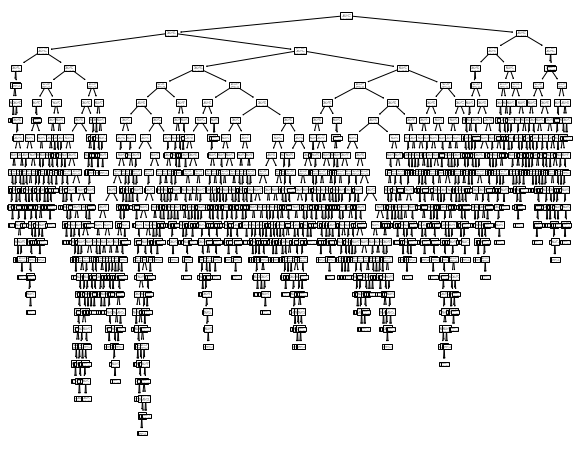

In [23]:
plt.figure(figsize=(10, 8))
plot_tree(tree_clf)
plt.show()

In [25]:
feature_names = ['alcohol', 'sugar', 'pH']
target_names = ['white', 'red']

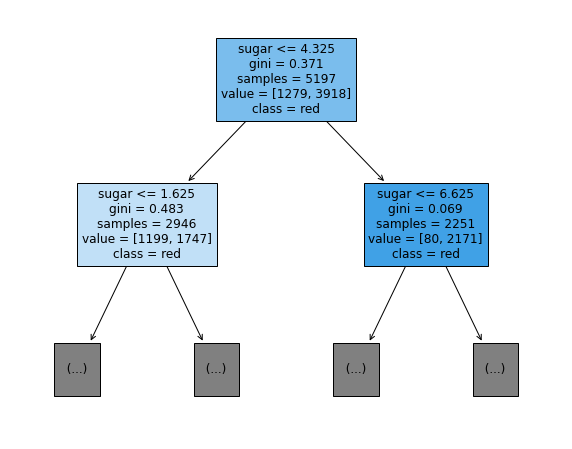

In [28]:
# tree가 너무 복잡하므로, depth=1까지만 시각화
plt.figure(figsize=(10, 8))
plot_tree(tree_clf, max_depth=1,
          feature_names=feature_names,
          class_names=target_names,
          filled=True)
plt.show()

In [29]:
# 이진 분류(binary class)에서 Gini 불순도 계산 방법:
# Gini impurity(불순도) = 1 - ((음성 클래스의 비율)**2 + (양성 클래스의 비율)**2)
1 - ((1279/5197)**2 + (3918/5197)**2)

0.37107315616915937

불순도(impurity):

*   두 클래스가 1:1로 섞여 있으면, 불순도는 최댓값.
>   1 - ((1/2)^2 + (1/2)^2) = 0.5

*   클래스가 완벽하게 분리되어 있으면(1:0, 0:1), 불순도는 최솟값.
>   1 - (1^2 + 0) or 1 - (0 + 1^2) = 0


Entropy(엔트로피) = - ((음성 클래스 비율) x log_2(음성 클래스 비율) + (양성 클래스 비율) x log_2(양성 클래스 비율))
